In [334]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt

In [340]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
GAMMA = .9
LR_actor = .01
LR_critic = .01
EXPERIENCE_CAPACITY = 7000
TARGET_UPDATE_FREQUENCY = 400
MAX_EPI = 70
MAX_STEP = 400
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

[2017-08-07 22:26:17,082] Making new env: Pendulum-v0


In [341]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [342]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 30)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 30)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fcO = nn.Linear(60, 1)
        self.fcO.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        s = F.relu(s)
        a = self.fcA(y)
        a = F.relu(a)
        o = self.fcO(torch.cat([s,a], 1))
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 30)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(30, N_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [348]:
def choose_action(state, actor):
    return (actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy() + \
            np.random.randn(1,1))[0]

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    # update critic
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.sum(critic(bat_o, actor(bat_o)))/bat_o.size()[0]
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def replace(target_net, net):
    target_net.load_state_dict(net.state_dict())

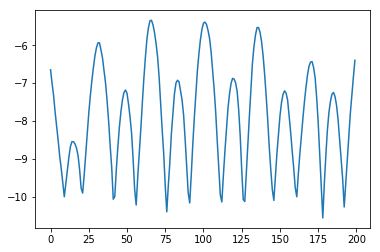

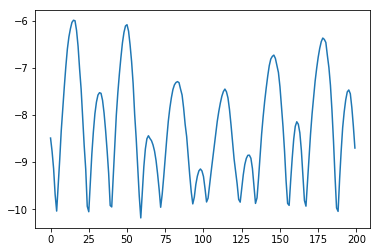

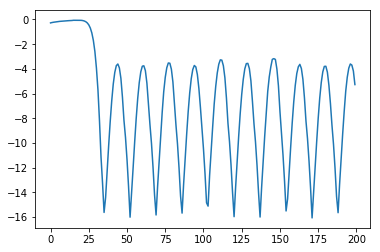

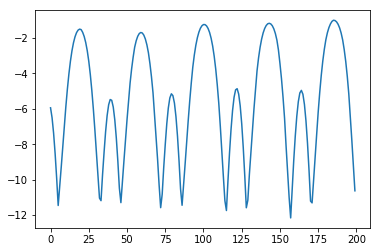

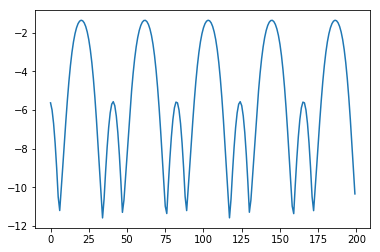

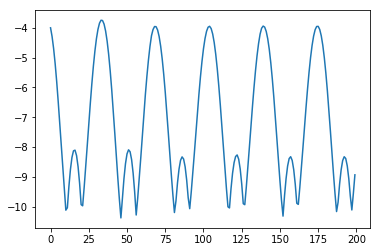

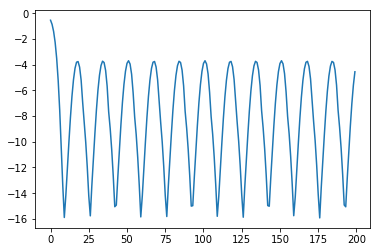

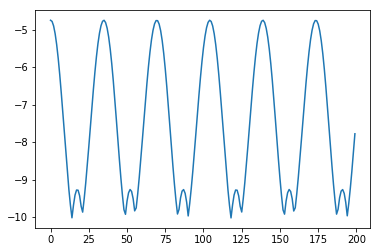

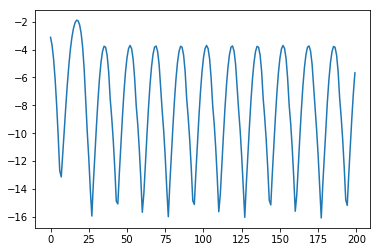

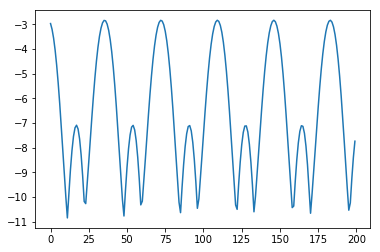

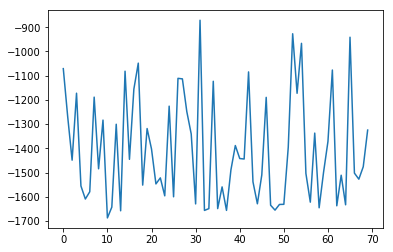

In [349]:
target_actor = Actor()
target_critic = Critic()
actor = Actor()
critic = Critic()
if use_cuda:
    target_actor.cuda()
    target_critic.cuda()
    actor.cuda()
    critic.cuda()
exp = Experience(EXPERIENCE_CAPACITY)
optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

vec_r = []
update_counter = 0
for epi in xrange(MAX_EPI):
    o = env.reset()
    acc_r = 0
    
    local_r = []
    
    for t in xrange(MAX_STEP):
        a = choose_action(o, actor)
        o_, r, done, info = env.step(a)
        #a = np.clip(a, -2, 2)
        exp.push(o, a, r, o_)
        
        update_actor_critic(target_actor, target_critic, \
                           actor, critic, exp, optim_actor, optim_critic)
        update_counter += 1
        
        #if update_counter % TARGET_UPDATE_FREQUENCY == 0:
        #    update_target(target_actor, target_critic, \
        #                 actor, critic)
        if update_counter % 300 == 0:
            replace(target_critic, critic)
        if update_counter % 500 == 0:
            replace(target_actor, actor)
        
        local_r.append(r)
        acc_r += r
        o = o_
        if done:
            break
            
    if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
        plt.plot(xrange(len(local_r)), local_r)
        plt.show()
    
    vec_r.append(acc_r)

plt.plot(xrange(MAX_EPI), vec_r)
plt.show()

In [262]:
x = np.array([[1,2,3],[4,5,6]])
print x[:,:1]
print x[:,1:2]

[[1]
 [4]]
[[2]
 [5]]


[[ 0.16427136  0.64244842  0.45357675  0.22938096]]
